In [38]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
%matplotlib inline

In [39]:
def load_data():
    load_dotenv()
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    alpaca = tradeapi.REST(
        alpaca_api_key,
        alpaca_secret_key,
        api_version="v2")
    end_date = pd.Timestamp("2023-04-12", tz="America/New_York").isoformat()
    today = pd.Timestamp("2010-09-16", tz="America/New_York").isoformat()
    tickers = ["SPY"]
    timeframe = "1Day"
    df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = end_date
    ).df
    # Only Returns 1 day so need to change that to specified number of days
    return df_portfolio

In [40]:
my_df = load_data()

In [41]:
my_df.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2015-12-01 05:00:00+00:00,209.440,210.8200,209.1100,210.680,97858418,337780,209.921410,SPY
2015-12-02 05:00:00+00:00,210.615,211.0000,208.2300,208.529,108069059,367013,209.563055,SPY
2015-12-03 05:00:00+00:00,208.830,209.1500,204.7511,205.610,166224154,546768,206.878936,SPY
2015-12-04 05:00:00+00:00,206.080,209.9700,205.9300,209.620,192878747,556731,208.178631,SPY
2015-12-07 05:00:00+00:00,209.230,209.7295,207.2000,208.350,102027111,374705,208.276128,SPY


In [42]:
def trading_algorithm(df):
    df = df.loc[:, ["close"]]
    df["Actual Returns"] = df["close"].pct_change()
    # calculate 50-day and 200-day moving averages
    df['50-day MA'] = df['close'].rolling(window=50).mean()
    df['200-day MA'] = df['close'].rolling(window=200).mean()
    temp = df[['close', 'Actual Returns']]
    temp2 = df[['50-day MA', '200-day MA']].shift().dropna()
    conc_df = pd.concat([temp, temp2], axis =1).dropna()
    # generate buy/sell signals based on MA crossovers
    # generate buy/sell signals based on MA crossovers
    conc_df['Signal'] = 0.0
    conc_df.loc[conc_df['50-day MA'] > conc_df['200-day MA'], 'Signal'] = 1  # Buy signal
    conc_df.loc[conc_df['50-day MA'] < conc_df['200-day MA'], 'Signal'] = -1  # Sell signal
    conc_df['Position'] = conc_df['Signal'].diff()
    conc_df = conc_df.dropna()
    
    return conc_df  

In [43]:
signal_df = trading_algorithm(my_df)

In [44]:
def training(df):
    X = signal_df.drop(columns='Signal')
    y = df['Signal']
    
    #Start Training
    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(years=3)
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]
    X_test = X.loc[training_end+DateOffset(hours=1):]
    y_test = y.loc[training_end+DateOffset(hours=1):]
    
    #  Standard Scaler instance
    scaler = StandardScaler()
    x_scaler = scaler.fit(X_train)
    x_train_scaled = x_scaler.transform(X_train)
    x_test_scaled = x_scaler.transform(X_test)
    
    # SVM instance
    svm_model = svm.SVC()
    svm_model = svm_model.fit(x_train_scaled, y_train)
    svm_pred = svm_model.predict(x_train_scaled)
    testing_signal_predictions = svm_model.predict(x_test_scaled)
    
    # Predictions Dataframe
    predictions_df = pd.DataFrame(index=X_test.index)
    predictions_df['Predicted'] = testing_signal_predictions
    predictions_df['Strategy Returns'] = df['Actual Returns'] * predictions_df['Predicted']
    df = pd.concat([df, predictions_df], axis =1)
    display(training_begin)
    return df

In [45]:
predictions_df = training(signal_df)

Timestamp('2016-09-19 04:00:00+0000', tz='UTC')

In [46]:
predictions_df = predictions_df.dropna()

In [47]:
predictions_df

,close,Actual Returns,50-day MA,200-day MA,Signal,Position,Predicted,Strategy Returns
timestamp,,,,,,,,
2019-09-20 04:00:00+00:00,298.08,-0.009931,294.986054,282.116768,1.0,0.0,1.0,-0.009931
2019-09-23 04:00:00+00:00,298.30,0.000738,294.961254,282.210869,1.0,0.0,1.0,0.000738
2019-09-24 04:00:00+00:00,295.92,-0.007979,294.914254,282.350418,1.0,0.0,1.0,-0.007979
2019-09-25 04:00:00+00:00,297.61,0.005711,294.815854,282.481168,1.0,0.0,1.0,0.005711
2019-09-26 04:00:00+00:00,297.00,-0.002050,294.772454,282.650918,1.0,0.0,1.0,-0.002050
...,...,...,...,...,...,...,...,...
2023-04-05 04:00:00+00:00,407.60,-0.002618,401.612000,392.985200,1.0,0.0,1.0,-0.002618
2023-04-06 04:00:00+00:00,409.19,0.003901,401.760000,393.193900,1.0,0.0,1.0,0.003901
2023-04-10 04:00:00+00:00,409.61,0.001026,401.936800,393.364500,1.0,0.0,1.0,0.001026


In [49]:
def max_drawdown(returns_df):
    returns = np.array(returns_df['Strategy Returns'])
    cumulative_returns = np.cumprod(1 + returns)
    max_cumulative_returns = np.maximum.accumulate(cumulative_returns)
    
    drawdowns = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns
    max_drawdown = np.min(drawdowns)
    
    return max_drawdown

In [50]:
mmd = max_drawdown(predictions_df)
mmd

-0.3919660567861133

In [66]:
def show_plots(predictions_df):
    entry = predictions_df[predictions_df["Position"] == 2.0]["close"].hvplot.scatter(
        color='purple',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    exit = predictions_df[predictions_df["Position"] == -2.0]["close"].hvplot.scatter(
        color='orange',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    security_close = predictions_df[["close"]].hvplot(
        line_color='lightgray',
        ylabel='Price in $',
        width=1000,
        height=400
    )

    moving_avgs = predictions_df[["50-day MA", "200-day MA"]].hvplot(
        ylabel='Price in $',
        width=1000,
        height=400
    )

    Actual_v_strat_returns = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
    entry_exit_plot = security_close * moving_avgs * entry * exit
    return entry_exit_plot


:Overlay
   .Curve.I          :Curve   [timestamp]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .Scatter.Close.I  :Scatter   [timestamp]   (close)
   .Scatter.Close.II :Scatter   [timestamp]   (close)

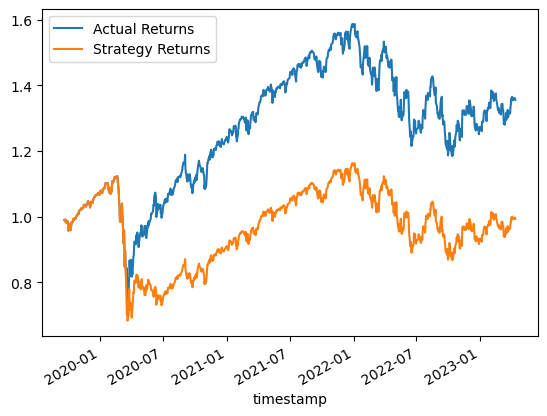

In [67]:
plots = show_plots(predictions_df)
plots